In [1]:
# importing libarires 

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle



# using the SQLite Table to read data.
con = sqlite3.connect('./amazon-fine-food-reviews/database.sqlite') 



#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 


# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

In [2]:

display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


In [3]:
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [4]:
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [5]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

In [6]:
final = final.iloc[:25000,:]
final.shape

(25000, 10)

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [8]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [9]:
# find sentences containing HTML tags

import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;

6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [10]:
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{'y', 'where', 'during', 'with', 'she', 'wasn', "that'll", 'we', 'yourself', 'all', 'too', 'and', 'each', 'now', "isn't", 'at', 'hasn', 'those', 'i', 'because', 'about', 'my', 'when', "weren't", 'you', 'doesn', "doesn't", 'so', 'themselves', 've', 'these', "you'll", 'same', 'just', 'being', 'why', 'was', 'for', "you'd", 'or', "you're", 'mustn', "mightn't", 'myself', 'an', 'by', 'again', 'of', 'himself', 'be', 'shouldn', 'once', 'them', 'here', 'both', 'own', "hadn't", 're', 'your', 'couldn', 'should', "didn't", 'haven', 'been', 'who', "should've", 'won', 'hadn', "mustn't", 'no', 'in', "couldn't", 'doing', 'against', 'not', "won't", "shouldn't", 'did', 'm', 'am', 'out', 'needn', 'were', 'shan', 'other', 'nor', 'his', 'most', 'our', 'over', 'her', 'from', 'then', 'how', 'up', 'ain', "haven't", 'only', 'than', 'a', 'to', "you've", 'didn', 'don', 'as', 'which', 'some', 'd', 'ourselves', 'ma', 'what', 'while', 'their', 'any', 'that', 'do', 'its', 'under', "hasn't", 'me', 'very', 'has', 'the

In [11]:
#Snowball Stemming the word
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [12]:
 #adding a column of CleanedText which displays the data after pre-processing of the review 
final['CleanedText']=final_string
final['CleanedText']=final['CleanedText'].str.decode("utf-8")

In [13]:
final.head(3) #below the processed review can be seen in the CleanedText Column 


# store final table into an SQlLite table for future.
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn,  schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

In [14]:
#convert the text into numerical using BOW technique
count_vect = CountVectorizer() #in scikit-learn
final_counts = count_vect.fit_transform(final['CleanedText'].values)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (25000, 21724)
the number of unique words  21724


In [15]:
# print the most commom poisitive and negative points
freq_dist_positive=nltk.FreqDist(all_positive_words)
freq_dist_negative=nltk.FreqDist(all_negative_words)
print("Most Common Positive Words : ",freq_dist_positive.most_common(20))
print("Most Common Negative Words : ",freq_dist_negative.most_common(20))

Most Common Positive Words :  [(b'use', 8452), (b'like', 7967), (b'love', 7188), (b'one', 6661), (b'good', 6544), (b'tast', 6491), (b'great', 6428), (b'product', 5941), (b'flavor', 5815), (b'food', 5696), (b'dog', 5619), (b'tri', 5347), (b'get', 5331), (b'tea', 5201), (b'make', 4909), (b'time', 4034), (b'treat', 3688), (b'would', 3622), (b'coffe', 3520), (b'well', 3514)]
Most Common Negative Words :  [(b'product', 1760), (b'like', 1694), (b'tast', 1478), (b'one', 1347), (b'food', 1315), (b'dog', 1249), (b'would', 1177), (b'use', 1085), (b'get', 1028), (b'tri', 959), (b'good', 876), (b'buy', 873), (b'order', 850), (b'cat', 798), (b'flavor', 784), (b'even', 770), (b'dont', 763), (b'time', 751), (b'bag', 699), (b'make', 692)]


In [16]:
# standarized the data before using T-sne technique for visualization 
from sklearn.preprocessing import StandardScaler
standardized_data = StandardScaler().fit_transform(final_counts[0:1000].toarray())
print(standardized_data.shape)

(1000, 21724)


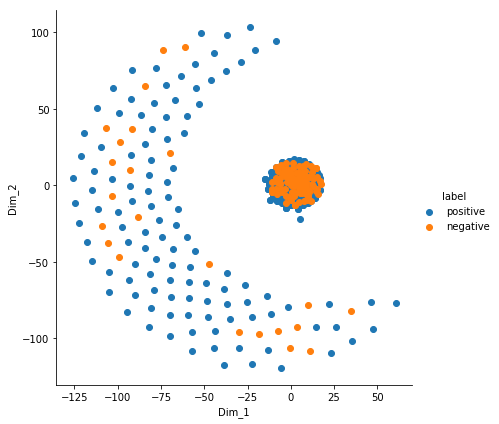

In [17]:
# T_SNE technique for visualization the data 
from sklearn.manifold import TSNE

# Picking the top 1000 points as TSNE takes a lot of time for 15K points
labels = final['Score'][0:1000]

model = TSNE(n_components=2, random_state=0)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(standardized_data)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

In [ ]:
# the above plot using BOW  Model here i use data 1K points for ploting 
# blue colour showing for poisitive points and orange colour showing for negative points

In [18]:
# TF_IDF Model for convert text into d-dimension vectar
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf = tf_idf_vect.fit_transform(final['CleanedText'].values)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (25000, 493780)
the number of unique words including both unigrams and bigrams  493780


In [19]:
features = tf_idf_vect.get_feature_names()
print("some sample features(unique words in the corpus)",features[100000:100010])


some sample features(unique words in the corpus) ['crave goe', 'crave good', 'crave grape', 'crave green', 'crave guess', 'crave gum', 'crave hasnt', 'crave hickori', 'crave hit', 'crave honey']


In [20]:
print(final_tf_idf[3,:].toarray()[0])

[0. 0. 0. ... 0. 0. 0.]


In [21]:
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

top_tfidf = top_tfidf_feats(final_tf_idf[1,:].toarray()[0],features,25)

In [22]:
top_tfidf

,feature,tfidf
0,hard cover,0.176490
1,cover version,0.176490
2,two hand,0.176490
3,page open,0.176490
4,version paperback,0.176490
5,movi incorpor,0.176490
6,rosi movi,0.176490
7,paperback seem,0.176490
8,incorpor love,0.176490
9,love son,0.176490


In [42]:
# standarized the data before using T-sne technique for visualization 

sklearn.preprocessing import StandardScaler
standardized_data = StandardScaler().fit_transform(final_tf_idf[0:100,:].toarray())                                                                                                                                                                                           

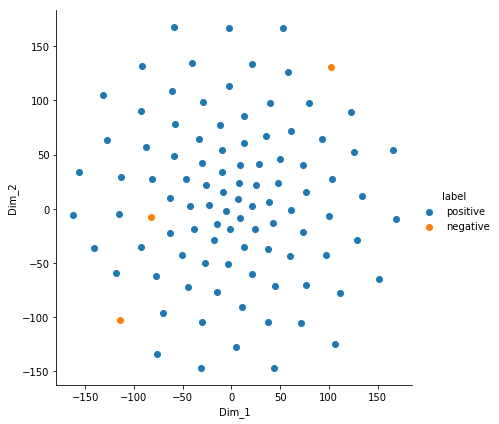

In [44]:
# T_SNE technique for visualization the data 

from sklearn.manifold import TSNE

# Picking the top 1000 points as TSNE takes a lot of time for 15K points
labels = final['Score'][0:100]

model = TSNE(n_components=2, random_state=0)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(standardized_data)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

In [ ]:
# the above plot using TFIDF  Model here i use data 100 points for ploting 
# blue colour showing for poisitive points and orange colour showing for negative points

In [37]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sent=[]
for sent in final['CleanedText'].values:
    list_of_sent.append(sent.split())

In [38]:
print(final['CleanedText'].values[0])
print("*****************************************************************")
print(list_of_sent[0])

witti littl book make son laugh loud recit car drive along alway sing refrain hes learn whale india droop love new word book introduc silli classic book will bet son still abl recit memori colleg
*****************************************************************
['witti', 'littl', 'book', 'make', 'son', 'laugh', 'loud', 'recit', 'car', 'drive', 'along', 'alway', 'sing', 'refrain', 'hes', 'learn', 'whale', 'india', 'droop', 'love', 'new', 'word', 'book', 'introduc', 'silli', 'classic', 'book', 'will', 'bet', 'son', 'still', 'abl', 'recit', 'memori', 'colleg']


In [27]:
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [28]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  7557
sample words  ['littl', 'book', 'make', 'son', 'laugh', 'loud', 'car', 'drive', 'along', 'alway', 'sing', 'hes', 'learn', 'whale', 'india', 'love', 'new', 'word', 'introduc', 'silli', 'classic', 'will', 'bet', 'still', 'abl', 'memori', 'colleg', 'grew', 'read', 'sendak', 'watch', 'realli', 'rosi', 'movi', 'incorpor', 'howev', 'miss', 'hard', 'cover', 'version', 'paperback', 'seem', 'kind', 'flimsi', 'take', 'two', 'hand', 'keep', 'page', 'open']


In [29]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list

for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

25000
50


In [46]:
standardized_data = StandardScaler().fit_transform(sent_vectors)

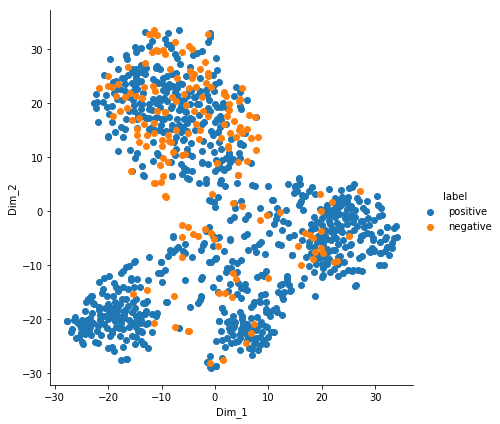

In [47]:
# T_SNE technique for visualization the data 

from sklearn.manifold import TSNE

# Picking the top 1000 points as TSNE takes a lot of time for 15K points
labels = final['Score'][0:1000]
df=standardized_data[0:1000,:]

model = TSNE(n_components=2, random_state=0)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(df)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

In [ ]:
# the above plot using Word2vec  Model here i use data 1K points for ploting 
# blue colour showing for poisitive points and orange colour showing for negative points

In [ ]:
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

In [33]:
# standarized the data 
standardized_data = StandardScaler().fit_transform(tfidf_sent_vectors)

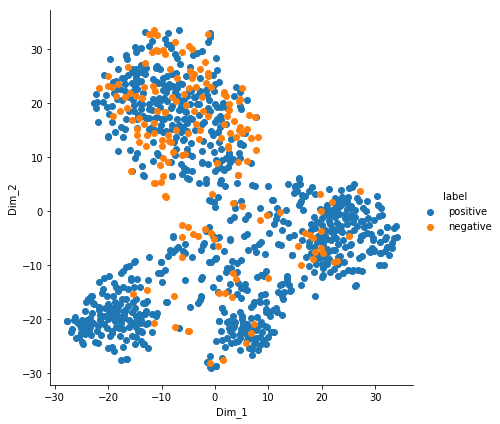

In [49]:
# T_SNE technique for visualization the data 

from sklearn.manifold import TSNE

# Picking the top 1000 points as TSNE takes a lot of time for 15K points
labels = final['Score'][0:1000]
df=standardized_data[0:1000,:]

model = TSNE(n_components=2, random_state=0)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(df)
tsne_data = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

In [ ]:
# the above plot using tfidf w2v  Model here i use data 1K points for ploting 
# blue colour showing for poisitive points and orange colour showing for negative points